This is the version based on https://heartbeat.comet.ml/build-train-and-deploy-a-book-recommender-system-using-keras-tensorflow-js-b96944b936a7

In [1]:
#import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [2]:
#import the dataset

ratings_df = pd.read_csv("final_ratings_new_ver.csv", encoding="latin-1")
resto_df = pd.read_csv("Restaurant_list_new_ver.csv", encoding="latin-1")
ratings_df.head()

,userID,placeID,rating
0,1001,1,4
1,1002,1,5
2,1003,1,4
3,1004,1,3
4,1005,1,5


In [3]:
#Let's see the rating dataset

print(ratings_df.shape)
print(ratings_df.userID.nunique())
print(ratings_df.placeID.nunique())
ratings_df.isna().sum()

(765, 3)
136
18


userID     0
placeID    0
rating     0
dtype: int64

In [27]:
#split the data to training (90%) and test (10%)

from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (612, 3)
Shape of test data: (153, 3)


In [28]:
#Get the number of unique entities in resto and users columns

n_placeID = ratings_df.placeID.nunique()
n_userID = ratings_df.userID.nunique()

In [38]:
#embedding process

#resto input network
input_resto = tf.layers.Input(shape=[1])
embed_resto = tf.layers.Embedding(n_placeID + 1500,100)(input_resto)
resto_out = tf.layers.Flatten()(embed_resto)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(n_userID + 1500,100)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([resto_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_resto, input_users], x_out)

In [39]:
#choosing optimizer and loss function

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 100)       151800      input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 100)       163600      input_8[0][0]                    
____________________________________________________________________________________________

In [40]:
#Train the model

hist = model.fit([Xtrain.placeID, Xtrain.userID], Xtrain.rating, 
                 batch_size=64, 
                 epochs=25, 
                 verbose=1,
                 validation_data=([Xtest.placeID, Xtest.userID], Xtest.rating))

Epoch 1/25
10/10 [==============================] - 0s 22ms/step - loss: 19.3752 - val_loss: 18.5211
Epoch 2/25
10/10 [==============================] - 0s 13ms/step - loss: 17.0042 - val_loss: 15.4421
Epoch 3/25
10/10 [==============================] - 0s 13ms/step - loss: 12.9069 - val_loss: 10.0702
Epoch 4/25
10/10 [==============================] - 0s 12ms/step - loss: 6.8609 - val_loss: 3.6393
Epoch 5/25
10/10 [==============================] - 0s 13ms/step - loss: 1.7463 - val_loss: 0.7605
Epoch 6/25
10/10 [==============================] - 0s 14ms/step - loss: 1.0459 - val_loss: 0.9147
Epoch 7/25
10/10 [==============================] - 0s 9ms/step - loss: 0.8169 - val_loss: 0.5964
Epoch 8/25
10/10 [==============================] - 0s 7ms/step - loss: 0.5979 - val_loss: 0.6676
Epoch 9/25
10/10 [==============================] - 0s 7ms/step - loss: 0.5896 - val_loss: 0.5902
Epoch 10/25
10/10 [==============================] - 0s 7ms/step - loss: 0.5462 - val_loss: 0.5751
Epoch 1

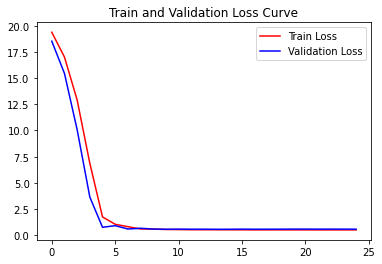

In [41]:
#plotting the losses

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [11]:
#save the model

model.save('modelv2')

INFO:tensorflow:Assets written to: model\assets


In [69]:
# tf.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [14]:
#Extract embeddings

resto_em = model.get_layer('embedding')
resto_em_weights = resto_em.get_weights()[0]
resto_em_weights.shape

(1518, 100)

In [15]:
#getting restaurant's name

resto_df_copy = resto_df.copy()
resto_df_copy = resto_df_copy.set_index("placeID")

In [18]:
#making tsv file

r_id =list(ratings_df.placeID.unique())
#r_id.remove(10000)
dict_map = {}
for i in r_id:
    dict_map[i] = resto_df_copy.iloc[i]['Nama_resto']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
for i in r_id:
    resto = dict_map[i]
    embeddings = resto_em_weights[i]
    out_m.write(resto + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

KeyError: 'Nama_resto'

In [19]:
#Making recommendations for user U1025

resto_arr = np.array(r_id) #get all resto IDs
user = np.array([25 for i in range(len(r_id))])
pred = model.predict([resto_arr, user])
pred

array([[3.6675303],
       [4.329722 ],
       [4.893011 ],
       [4.138033 ],
       [3.2694032],
       [3.991177 ],
       [3.091033 ],
       [4.0577245],
       [2.8280668],
       [4.151769 ],
       [4.1239343],
       [3.3585606],
       [3.3469152],
       [3.1582155],
       [4.3777266],
       [4.215227 ],
       [3.2813897],
       [2.532134 ]], dtype=float32)

In [20]:
#retrival process (top 10)

pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:10]
pred_ids

array([ 2, 14,  1, 15,  9,  3, 10,  7,  5,  0])

In [21]:
#getting the top 10 restos data

resto_df.iloc[pred_ids]

,placeID,Nama_resto
2,3,Cafe Halaman
14,15,The Valley
1,2,Braga Permai Resto
15,16,Tizi's
9,10,Miss Bee Providore
3,4,Dusun Bambu
10,11,Raja Rasa
7,8,Karnivor
5,6,Hummingbird Eatery
0,1,Atmosphere Resort Cafï¿½
